In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sn
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

import pandas as pd
import numpy as np
import os
import glob

### *functions*

In [101]:
def get_label_from_filename(filename): 
    if "Phantom" in filename: return "Phantom"
    elif "Ruko_F11_Pro" in filename: return "Ruko_F11_Pro"
    elif "Ruko_F11_base" in filename: return "Ruko_F11_base"
    elif "Mavic_Air_2_" in filename: return "Mavic_Air_2"
    elif "Mavic_Air_2S" in filename: return "Mavic_Air_2S"
    elif "DeerC" in filename: return "DeerC"
    elif "Mini_SE" in filename: return "Mini_SE"
    elif "test" in filename: return "test"
    elif "None" in filename: return "None"
    else: return "UNKNOWN_LABEL"



def load_iq(f, chunk_size, every_n_rows):
    # The chunking in this algo is so that we can read in large files (156M lines or more). 
    # In order to reduce compution time, we skip n number of rows. 
    result = pd.DataFrame()

    for chunk in pd.read_csv(f, chunksize=chunk_size):
        result = pd.concat([result, chunk.iloc[::every_n_rows, :]], ignore_index=True)

    # print("THE DF:\n", result)
    result = result[['i', 'q']].to_numpy()
    return result

    

### *variables*

In [102]:
# Path to your IQ files
data_dir = "./data/"
drone_csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(drone_csv_files)

chunk_size = 10_000 # how many rows to hold in memory at a time
every_n_rows = 30

# Example: sample windows with 50% overlap
window_size = 4096 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
step = 1024

['./data/iqSamples_Ruko_F11_Pro.csv', './data/iqSamples_Phantom.csv', './data/iqSamples_Mini_SE.csv', './data/iqSamples_Mavic_Air_2_.csv', './data/iqSamples_Holystone_HS100.csv', './data/iqSamples_Ruko_F11_base.csv', './data/iqSamples_Mavic_Air_2S.csv', './data/iqSamples_None.csv', './data/iqSamples_DeerC_DE2.csv']


### *Reading in files*

In [ ]:
X = []
y = []

segments = []
labels = []


# create an array of dataframes.
# each dataframe containing iq samples from one file
for file in drone_csv_files:
    print("File: ", file)
    label = get_label_from_filename(file)
    # print("Label: ", label)
    iq = load_iq(file, chunk_size, every_n_rows)  # shape (N, 2)
    # print("File:\n", iq)
    for i in range(0, len(iq)-window_size, step):
        window = iq[i:i+window_size].flatten()
        segments.append(window)
        labels.append(label)
    # print("Segments:\n", segments)
    # print("Labels:\n", labels)

X = np.array(segments)
y = np.array(labels)

File:  ./data/iqSamples_Ruko_F11_Pro.csv


In [ ]:
print("Segments:")
print("Shape: ", X.shape)
print(X)
print("-------------------------------------------------------------------")
print("Labels:")
print("Shape: ", y.shape)
print(y)

Segments:
Shape:  (38611, 8192)
[[-3384. -5693. -1360. ...  -158.  -347.   189.]
 [ -158.  -189.  -316. ...   158.   -63.   -94.]
 [ -221.  -126.    94. ...   -31.     0.   411.]
 ...
 [   51.   -17.  -206. ...  -103.  -103.    85.]
 [ -171.   -34.  -154. ...   -68.  -171.   103.]
 [   68.   -85.   -34. ...    51.  -223.   -17.]]
-------------------------------------------------------------------
Labels:
Shape:  (38611,)
['Ruko_F11_Pro' 'Ruko_F11_Pro' 'Ruko_F11_Pro' ... 'DeerC' 'DeerC' 'DeerC']


In [ ]:
# print("labels: ")
# print(np.unique(y))
# print()

for sample, label in zip(X, np.unique(y)): 
    print("X feature:\n", sample)
    print("IQ samples in X feature: ", int(sample.size / 2))
    print("y label: ", label)
    print('------------------------------------------------------')

X feature:
 [-3384. -5693. -1360. ...  -158.  -347.   189.]
IQ samples in X feature:  4096
y label:  DeerC
------------------------------------------------------
X feature:
 [-158. -189. -316. ...  158.  -63.  -94.]
IQ samples in X feature:  4096
y label:  Mavic_Air_2
------------------------------------------------------
X feature:
 [-221. -126.   94. ...  -31.    0.  411.]
IQ samples in X feature:  4096
y label:  Mavic_Air_2S
------------------------------------------------------
X feature:
 [-442.  379.  -63. ... -126. -790.  316.]
IQ samples in X feature:  4096
y label:  Mini_SE
------------------------------------------------------
X feature:
 [158. 347.  31. ...  94.   0.   0.]
IQ samples in X feature:  4096
y label:  None
------------------------------------------------------
X feature:
 [-126. -253. -126. ...  -94. -442.  347.]
IQ samples in X feature:  4096
y label:  Phantom
------------------------------------------------------
X feature:
 [ -31. -253.  126. ...   63. -569. -

### *Training, fitting & predicting*

In [ ]:
# Train/test split (e.g. 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
SVCModel = SVC(kernel='rbf', C=10, gamma='scale', max_iter=160_000)  # tweak C/gamma as needed
SVCModel.fit(X_train, y_train)
y_pred = SVCModel.predict(X_test)


### *Prediction & metrics*

In [ ]:
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cr)
print(f"Accuracy: {accuracy:.4f}")
print()
print(cm)

               precision    recall  f1-score   support

        DeerC       0.23      0.83      0.37       953
  Mavic_Air_2       0.00      0.00      0.00       953
 Mavic_Air_2S       0.41      0.07      0.12       954
      Mini_SE       0.40      0.23      0.30       954
         None       0.57      1.00      0.73       954
      Phantom       0.56      0.47      0.51       953
 Ruko_F11_Pro       0.89      0.10      0.18       954
Ruko_F11_base       0.82      0.80      0.81       953
UNKNOWN_LABEL       1.00      0.41      0.58        95

     accuracy                           0.44      7723
    macro avg       0.54      0.44      0.40      7723
 weighted avg       0.49      0.44      0.38      7723

Accuracy: 0.4383

[[794   2   1   5 147   4   0   0   0]
 [711   0   0   9 228   4   0   1   0]
 [766  16  65  36   0  64   6   1   0]
 [138   6  16 224 154 250   2 164   0]
 [  0   0   0   0 954   0   0   0   0]
 [179  19  56 213  33 449   2   2   0]
 [621   3  18  24 156  35  94 

[[794   2   1   5 147   4   0   0   0]
 [711   0   0   9 228   4   0   1   0]
 [766  16  65  36   0  64   6   1   0]
 [138   6  16 224 154 250   2 164   0]
 [  0   0   0   0 954   0   0   0   0]
 [179  19  56 213  33 449   2   2   0]
 [621   3  18  24 156  35  94   3   0]
 [167  15   2   1   0   0   2 766   0]
 [  8   2   2  42   0   0   0   2  39]]


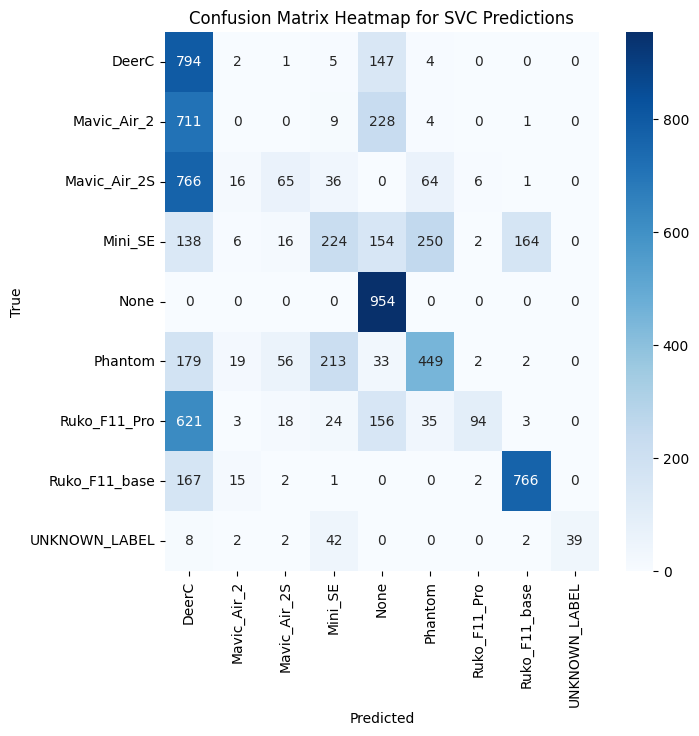

In [ ]:
# Create a heatmap of the confusion matrix

print(cm)

plt.figure(figsize=(7, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap for SVC Predictions')

plt.show()


ValueError: y must be an integer array. Found <U13. Try passing the array as y.astype(np.int_)

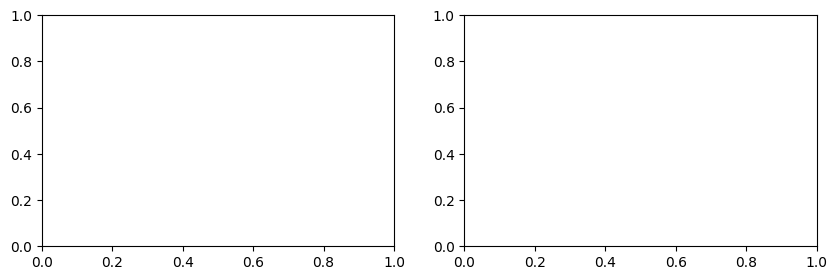

In [ ]:
%%script false --no-raise-error # uncomment this to skip execution of this cell

# Display the decision boundary with training data
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

fig = plot_decision_regions(X_train, y_train, SVCModel, ax = ax[0], zoom_factor=0.5)
ax[0].set_xlabel('In-Phase (I)', fontsize = 14)
ax[0].set_ylabel('Quadrature Phase (Q)', fontsize = 14)
ax[0].set_title('SVC (train)', fontsize = 14)
ax[0].set_xlim(-2.5, 10.5)
ax[0].set_ylim(-2.5, 2.5)

# Display the decision boundary with testing data
fig = plot_decision_regions(X_test, np.ravel(y_test), SVCModel, ax = ax[1], zoom_factor=0.25)
ax[1].set_xlabel('In-Phase (I)', fontsize = 14)
ax[1].set_title('SVC (test)', fontsize = 14)
ax[1].set_xlim(-2.5, 10.5)
ax[1].set_ylim(-2.5, 2.5)

plt.show()